In [1]:
# !pip install imbalanced-learn

In [2]:
import sys
sys.path.append('../src/')
import pandas as pd 
import numpy  as np
import matplotlib.pyplot as plt 
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import config, helper


In [3]:
df_folds = pd.read_csv(config.FOLD_DATA)
df_folds.drop('cus_dob', axis=1, inplace=True)
df_folds.head()

,age,cus_month_income,cus_gender,cus_marital_status,cus_customer_since,years_with_us,total_debit_trans_s1,total_debit_trans_s2,total_debit_trans_s3,total_debit_amt_s1,...,total_credit_amt_s3,total_debit_amt,total_debit_trans,total_credit_amt,total_credit_trans,total_transactions,cus_target,tar_desc,status,kfold
0,42,2.000000e+06,MALE,SINGLE,2005-09-05,14,1,6,1,817.02,...,0.00,27700.34,8,0.00,0,8,2222,MIDLE,ACTIVE,0
1,41,2.000000e+06,MALE,SINGLE,2005-05-23,14,13,6,6,9760362.69,...,389959.36,12868216.67,25,5014366.36,21,46,2211,PLATINUM,ACTIVE,5
2,56,3.421863e-03,MALE,SINGLE,1995-03-17,24,26,20,0,255579.65,...,0.00,297687.54,46,0.00,0,46,2222,MIDLE,CHURN,5
3,50,1.000000e+06,MALE,MARRIED,2005-09-29,14,18,16,17,38900.00,...,49730.34,123093.60,51,131133.33,21,72,2223,LOW,ACTIVE,4
4,14,1.000000e+07,MALE,SINGLE,2005-08-12,14,8,0,0,24205.63,...,48857.23,24205.63,8,145053.11,36,44,2223,LOW,ACTIVE,6


In [4]:
bins = [0, 20, 30, 40, 50, 60, 70, 120]  # Define age groups
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']  # Labels for age groups
df_folds['age_group'] = pd.cut(df_folds['age'], bins=bins, labels=labels, right=False)


In [5]:
data  = df_folds.groupby('kfold')['status'].agg({'value_counts'}).reset_index()   
data

,kfold,status,value_counts
0,0,ACTIVE,103
1,0,CHURN,22
2,1,ACTIVE,103
3,1,CHURN,22
4,2,ACTIVE,102
5,2,CHURN,23
6,3,ACTIVE,102
7,3,CHURN,23
8,4,ACTIVE,102
9,4,CHURN,23


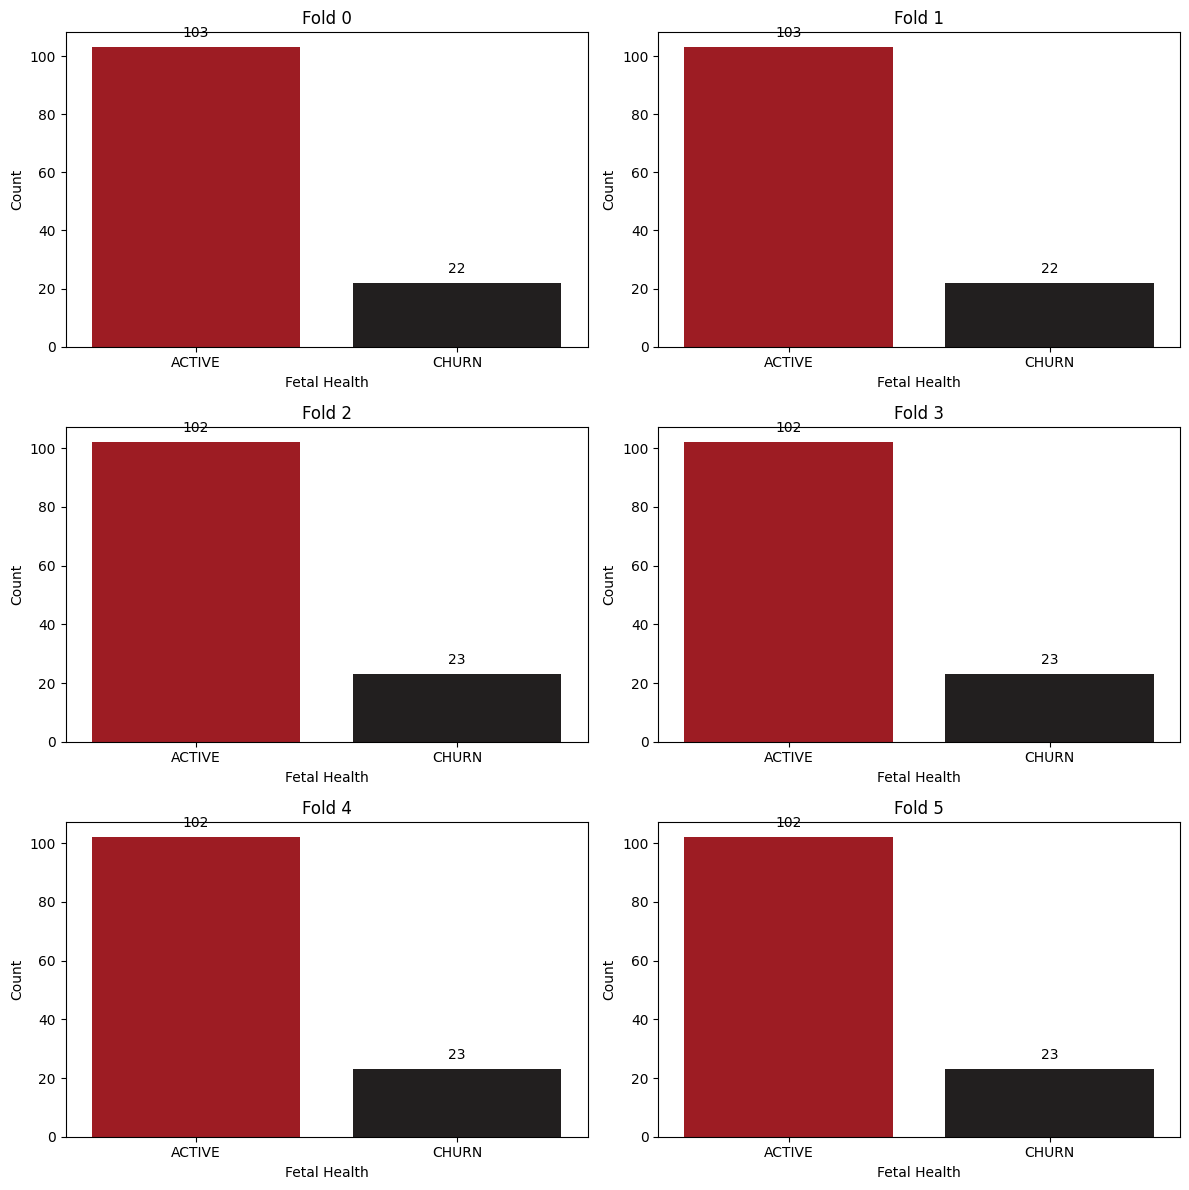

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
colours=["#b20710", "#221f1f"]
# Plot distribution for each fold
for i, ax in enumerate(axes.flat):
    fold_data = data[data['kfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='status', y='value_counts', ax=ax, palette=colours, hue='status')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')
        
    else:
        break

plt.tight_layout()
plt.savefig(config.PLOT_FILES+"dist_of_class_in_folds.jpg")
plt.show()

### <center><b><u><span style="color:#ff6600">OBSERVATIONS✍️</span></u></b></center>

* In each `fold`, there is a noticeable class imbalance between `"ACTIVE"` and `"CHURN"` classes. The "ACTIVE" class appears more frequently than the "CHURN" class.

* It seems like after using `StratifiedKFold` to create your folds, our target classes are distributed badly I would say. However, if the majority class (class 1.0) is significantly larger than the minority classes (classes 2.0 and 3.0), we still end up with `imbalanced folds`.

**`we might want to consider techniques such as class weighting, `resampling method`s (e.g., `oversampling` the minority class), or using `evaluation metrics` that are sensitive to class imbalance to ensure that our model effectively learns from both classes and generalizes well`**

## <center>`Lets understand **Undersampling** and **Oversampling**`</center>

**Oversampling:** In oversampling, you increase the number of instances of the minority class (in our case, "CHURN") to balance the class distribution. This can be done using techniques like `SMOTE (Synthetic Minority Over-sampling Technique)`, `ADASYN (Adaptive Synthetic Sampling)`, or simply by duplicating instances from the minority class.

**Undersampling:** In undersampling, you decrease the number of instances of the majority class (in this case, "ACTIVE") to balance the class distribution. This can involve randomly removing instances from the majority class until a more balanced distribution is achieved.

<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*7xf9e1EaoK5n05izIFBouA.png" alt="Image" />
</div>


<hr><hr>

### <b><u><span style="color:#ff6600">Each technique has its own set of advantages and disadvantages:</span></u></b></center></span></u></b>
#### `Undersampling:`

**Pros:**

- **`Reduces Training Time`**: By reducing the number of instances in the majority class, undersampling can significantly decrease training time, especially for algorithms sensitive to large datasets.
- **`Simplifies Model Interpretation`**: With a more balanced dataset, models may be simpler and easier to interpret, as they don't need to learn the nuances of the majority class as extensively.
- **`May Improve Performance on the Minority Class`**: By focusing more on the minority class, models trained on undersampled data may achieve higher precision, recall, or other performance metrics for the minority class.

**Cons:**

- **`Information Loss`**: Removing instances from the majority class can lead to the loss of potentially valuable information, which may degrade the model's ability to generalize to unseen data.
- **`Risk of Overfitting`**: Undersampling may increase the risk of overfitting, particularly if the dataset is already limited in size.
- **`Biased Representation`**: The reduced representation of the majority class may not accurately reflect its true distribution, leading to biased model predictions.

<hr>

#### `Oversampling:`

**Pros:**

- **`Preserves Information`**: Oversampling techniques generate synthetic samples or replicate existing minority class instances, preserving information from the minority class and potentially improving model performance.
- **`Balances Class Distribution`**: By increasing the representation of the minority class, oversampling can help balance the class distribution, reducing bias in model predictions.
- **`Reduces Risk of Overfitting`**: Oversampling increases the amount of training data available to the model, which can reduce the risk of overfitting, especially in cases of severe class imbalance.

**Cons:**

- **`Potential Overfitting`**: Oversampling can introduce synthetic data points that may not accurately represent the true distribution of the minority class, leading to overfitting, especially if not carefully implemented.
- **`Increased Computational Cost`**: Generating synthetic samples or replicating minority class instances can increase computational cost, especially for large datasets.
- **`Model Sensitivity`**: Some oversampling techniques may introduce noise or patterns that are not representative of the underlying data distribution, potentially leading to decreased model performance.

<hr><hr>



``Note:In our case Oversampling the "CHURN" class might be a better choice. By generating synthetic samples or duplicating instances from the "CHURN" class, you can increase its representation in the dataset and balance the class distribution. This approach can help prevent the model from being biased towards the majority class and improve its ability to learn patterns from the minority class. But we will try both and we'll see which one is better for our case``

In [9]:
df = pd.read_csv(config.CLEAN_FILE)
df.drop('cus_dob', axis=1, inplace=True)
df.head()

,age,cus_month_income,cus_gender,cus_marital_status,cus_customer_since,years_with_us,total_debit_trans_s1,total_debit_trans_s2,total_debit_trans_s3,total_debit_amt_s1,...,total_credit_amt_s2,total_credit_amt_s3,total_debit_amt,total_debit_trans,total_credit_amt,total_credit_trans,total_transactions,cus_target,tar_desc,status
0,49,7116.64,MALE,MARRIED,1994-06-30,25,277,265,345,1459126.64,...,1764079.61,2378592.62,4758311.63,887,5659653.33,65,952,2231,EXECUTIVE,ACTIVE
1,46,1500000.00,FEMALE,SINGLE,2005-05-19,14,37,15,45,35372.55,...,19500.00,57500.00,139363.22,97,87000.00,10,107,2223,LOW,ACTIVE
2,53,5000000.00,FEMALE,SINGLE,2005-05-20,14,31,14,8,28248.85,...,240311.84,70946.86,37375.46,53,1020883.70,27,80,2222,MIDLE,ACTIVE
3,15,500.00,FEMALE,SINGLE,2005-05-20,14,0,1,0,0.00,...,28089.99,18753.92,4000.00,1,76946.96,12,13,2223,LOW,ACTIVE
4,48,9000000.00,FEMALE,SINGLE,2014-06-30,5,15,33,12,69083.38,...,176000.00,70500.00,338470.29,60,442100.00,21,81,2223,LOW,ACTIVE


In [24]:
cat_cols = df.select_dtypes(include='object')
df_enc = helper.label_encode_categorical(df, cat_cols.columns)


In [14]:

X = df_enc.drop(columns=["status"], axis=1)
y = df_enc["status"]

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

df_smote = pd.concat(
    [
        pd.DataFrame(X_smote, columns=X.columns), 
        pd.Series(y_smote, name="status")
    ], 
    axis=1
)
df_smote
df_smote.to_csv("../data/Cleaned data/df_smote.csv", index=False)


**We successfully created our oversampled datasets now let create folds and then see the distribution of classes in each folds**

In [10]:
smote_df = pd.read_csv(config.SMOTE_FOLD_FILES)
smote_data  = smote_df.groupby('kfold')['status'].agg({'value_counts'}).reset_index()   
smote_data

,kfold,status,value_counts
0,0,1,103
1,0,0,102
2,1,1,103
3,1,0,102
4,2,0,103
5,2,1,102
6,3,0,103
7,3,1,102
8,4,0,102
9,4,1,102


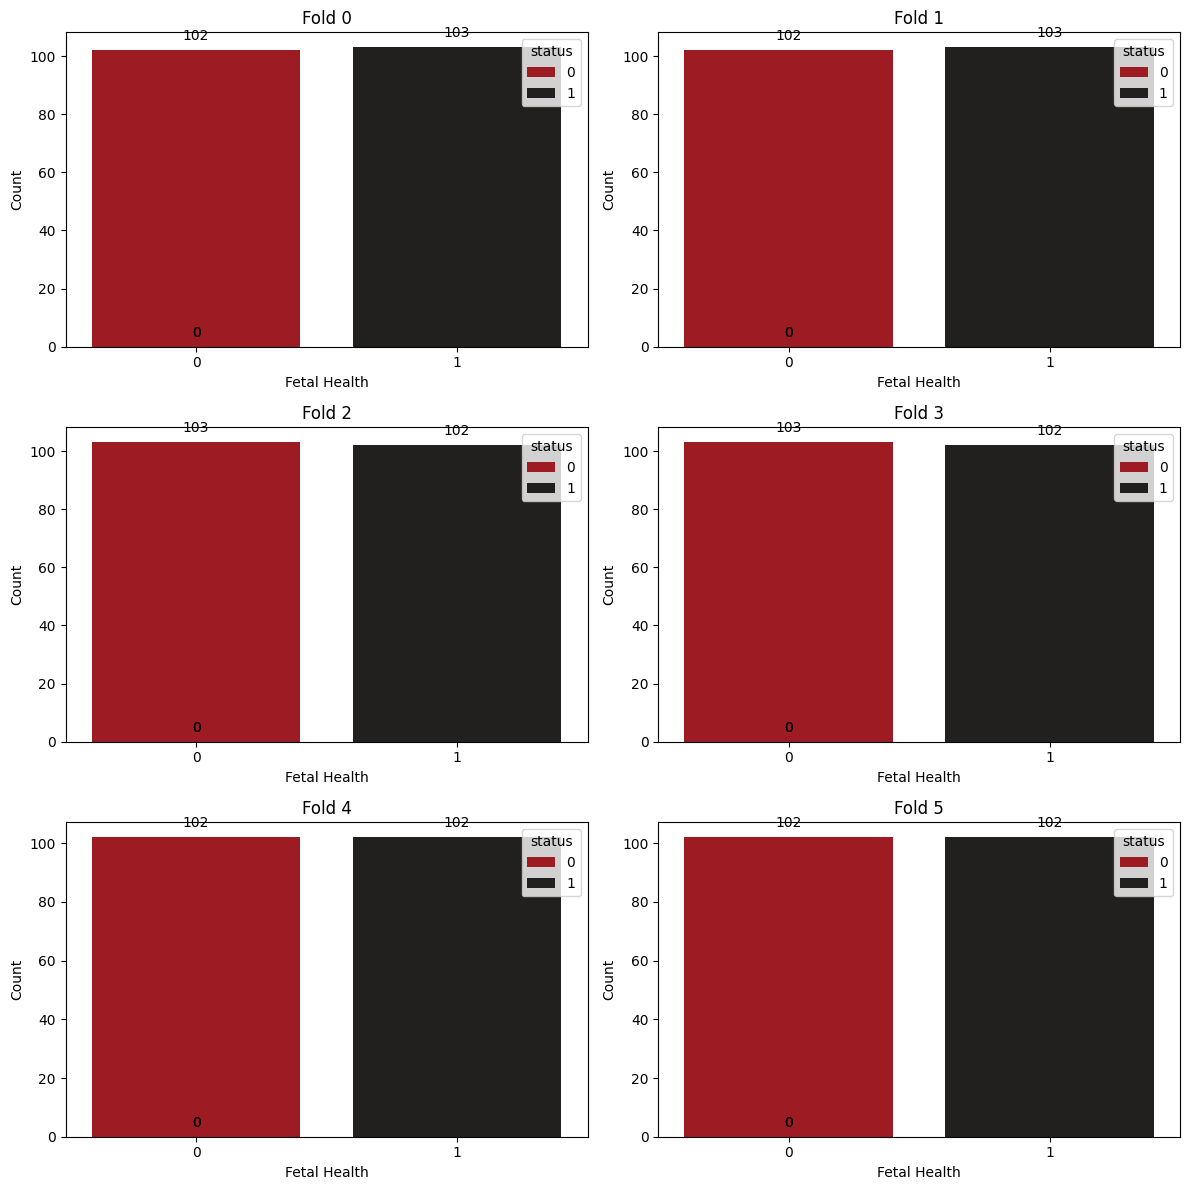

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    fold_data = smote_data[smote_data['kfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='status', y='value_counts', ax=ax, palette=colours, hue='status')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')
        
    else:
        break

plt.tight_layout()
plt.savefig(config.PLOT_FILES+"dist_of_class_using_smote_in_folds.jpg")
plt.show()

### <center><b><u><span style="color:#ff6600">OBSERVATIONS✍️</span></u></b></center>

The class distribution after applying `SMOTE oversampling technique`. It seems that the class distribution is now balanced in each fold, with both classes (0 and 1) having approximately the same number of instances.

#### **Reasons why❓, in my perspective, it works**:
- It helps address the issue of class imbalance in your dataset. By generating synthetic samples for the minority class (1), SMOTE has effectively increased its representation to match that of the majority class (0), resulting in a more balanced dataset.
- A balanced class distribution is beneficial for training machine learning models, as it helps prevent bias towards the majority class and allows the model to learn from both classes equally. This can lead to improved model performance and better generalization to unseen data.


# <center>`Let's go on to developing a model with smote dataset that just now we have created above and made a 10 folds for cross validation. `</center>




In [25]:

X = df_enc.drop(columns=["status"], axis=1)
y = df_enc["status"]

undersampler  = RandomUnderSampler()
X_under, y_under = undersampler .fit_resample(X, y)

df_under = pd.concat(
    [
        pd.DataFrame(X_under, columns=X.columns), 
        pd.Series(y_under, name="status")
    ], 
    axis=1
)
df_under
df_under.to_csv("../data/Cleaned data/df_undersample.csv", index=False)
